In [1]:
! nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:

!git clone https://github.com/nanekja/pytorch_utils

Cloning into 'pytorch_utils'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 26 (delta 12), reused 18 (delta 6), pack-reused 0
Receiving objects: 100% (26/26), 6.61 KiB | 3.31 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [3]:
import sys 
#sys.path.append('/content/pytorch_utils')
sys.path.append('./pytorch_utils/')

In [4]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

!pip install torchsummary

!pip install tqdm

from tqdm import tqdm
from torchsummary import summary
import sys
import os
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

!pip install albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import utils
import model
import train1
import test1
import dataloader


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cpu


In [6]:
# loading the dataset
exp = torchvision.datasets.CIFAR10('./data', train=True, download=True)
exp_data = exp.data
mean, std = utils.get_mean_and_std(exp_data)
exp.data.shape # train data shape

Files already downloaded and verified
 - Dataset Numpy Shape: (50000, 32, 32, 3)
 - Min: [0. 0. 0.]
 - Max: [1. 1. 1.]
 - Mean: [0.49139968 0.48215841 0.44653091]
 - Std: [0.24703223 0.24348513 0.26158784]
 - Var: [15.56135559 15.11767693 17.44919073]


(50000, 32, 32, 3)

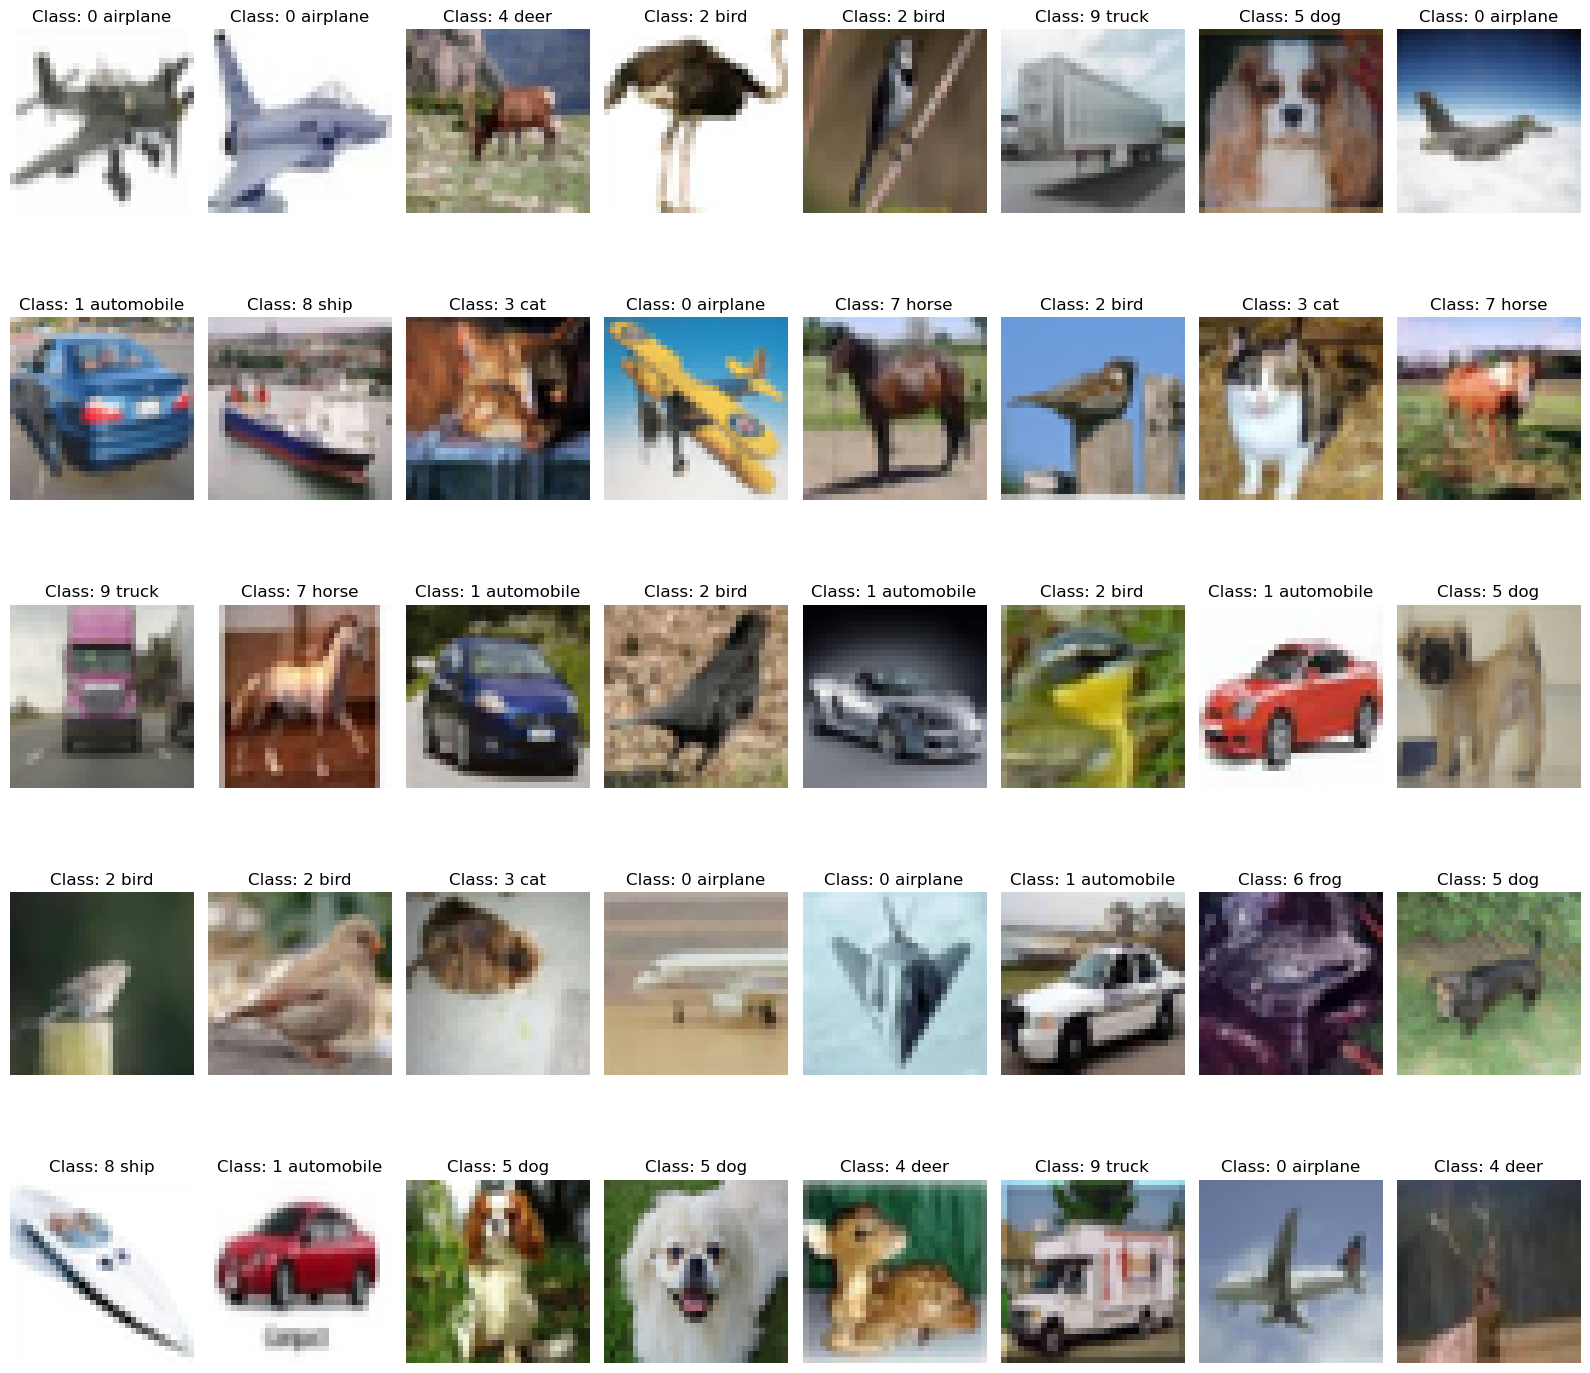

In [7]:
utils.plot_data(exp,5,8)

In [8]:
train_transforms = A.Compose([
    A.Normalize(
        mean=(0.49139968, 0.48215841, 0.44653091),
        std=(0.24703223, 0.24348513, 0.26158784),
    ),
    A.HorizontalFlip(),
    A.ShiftScaleRotate(),
    A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=(0.49139968, 0.48215841, 0.44653091), mask_fill_value=None)
])

test_transforms = A.Compose([
    A.Normalize(
        mean=[0.49139968, 0.48215841, 0.44653091],
        std=[0.24703223, 0.24348513, 0.26158784],
    )
])
     

In [9]:
SEED = 69

torch.manual_seed(SEED)

batch_size=32

trainset = dataloader.Cifar10Dataset(root='./data', train=True, download=True, transform=train_transforms)
testset = dataloader.Cifar10Dataset(root='./data', train=False, download=True, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 32, 32])
torch.Size([32])


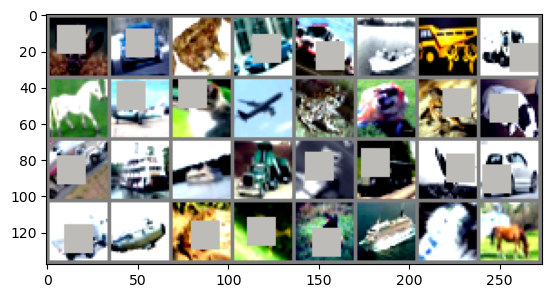

In [10]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

# show images
utils.imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
from model import Net
model = Net().to(device)

!pip install torchscan --no-deps
from torchscan import summary

#summary(model, (3, 32, 32), receptive_field=True, max_depth=1)

Defaulting to user installation because normal site-packages is not writeable


In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

EPOCHS = 2
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train1.train(model, device, train_loader, optimizer, epoch)
    test1.test(model, device, test_loader)


EPOCH: 1


Loss=1.4726237058639526 Batch_id=1562 Accuracy=30.92: 100%|██████████| 1563/1563 [03:46<00:00,  6.89it/s]


AttributeError: module 'test' has no attribute 'test'

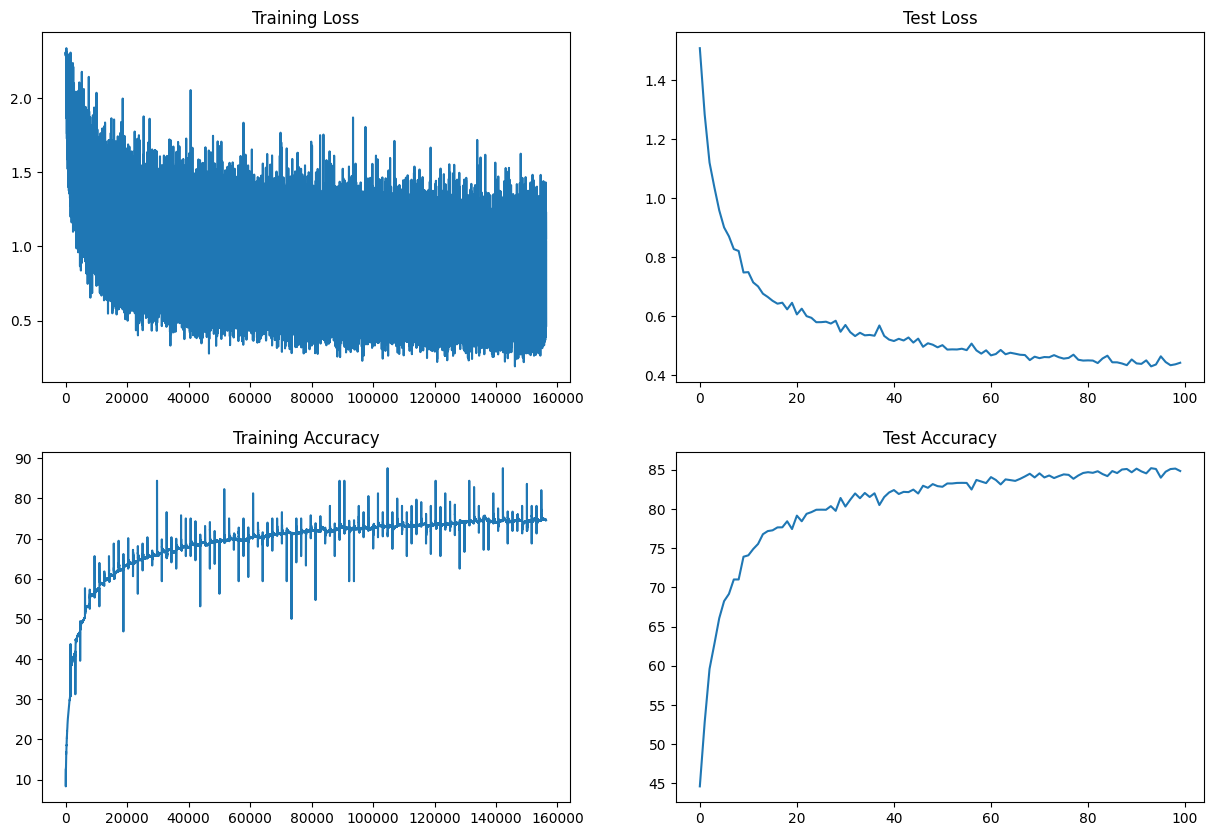

In [ ]:
utils.draw_graphs(train_losses, train_acc, test_losses, test_acc)

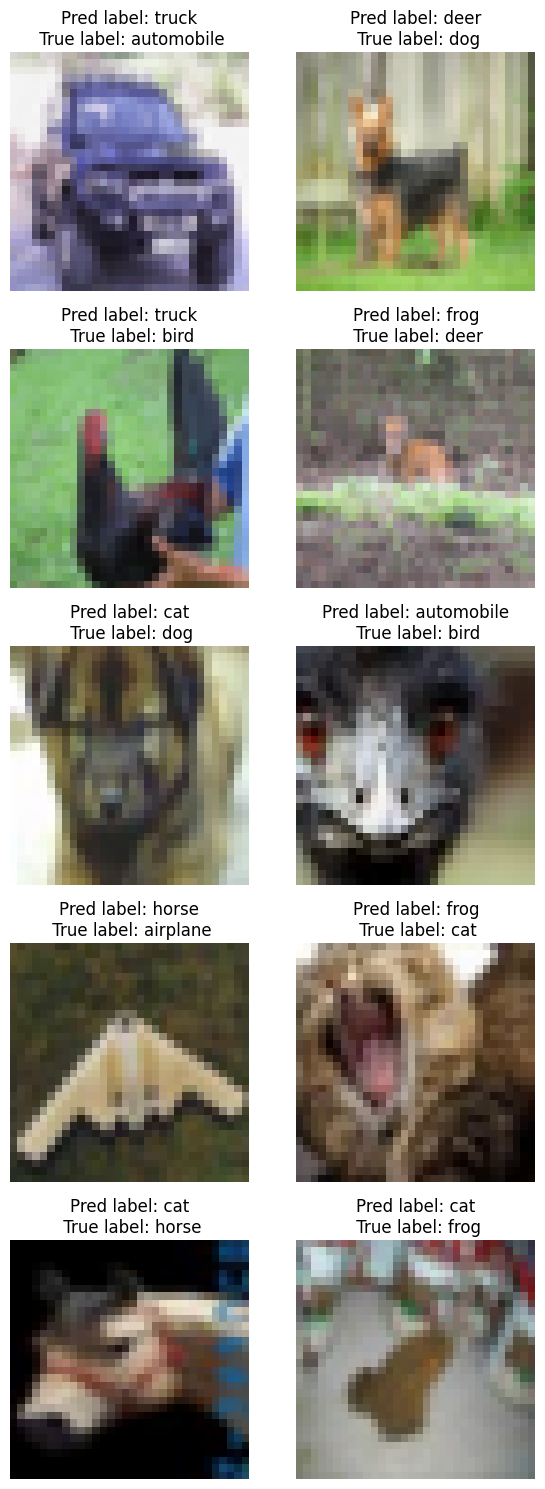

In [ ]:
misclf = utils.plot_misclassified(model, test_loader, testset.classes, device, mean, std, no_misclf=10, plot_size=(5,2), return_misclf=True)

In [ ]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

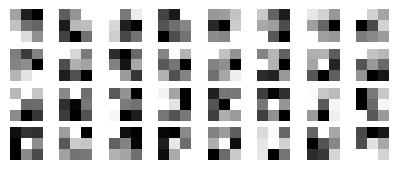

In [ ]:
# visualize the first conv layer filters
plt.figure(figsize=(5, 4))
first_layer_weights = model_weights[0].cpu()
for i, filter in enumerate(first_layer_weights):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()